## Importing the required libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import tensorflow.keras.backend as K

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Helper function for saving the plot.

In [3]:
IMAGES_PATH = Path() / "figures"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### Defining the global variables

In [4]:
IMAGE_SIZE = 128
BATCH_SIZE = 64
CHANNELS = 3
EPOCHS = 40
LEARNING_RATE = 0.001
BETA = 2000
NUM_FEATURES = 128
Z_DIM = 200

In [5]:
data_dir_path = "/content/drive/MyDrive/Dataset"

### `image_dataset_from_directory` perform image augmentation and set the image size of each image as (128 , 128)

In [6]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_path,
    labels=None,
    color_mode="rgb",
    interpolation="bilinear",
    shuffle=True,
    seed=1337,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

Found 2563 files belonging to 1 classes.


### Normalization using a custom function `preprocessing`

In [7]:
def preprocessing(img):
  images = tf.cast(img , "float32") / 255.0
  return images

In [8]:
train_dataset = train_dataset.map(lambda x : preprocessing(x))

In [9]:
for i in train_dataset.take(1):
  print(i.shape)

(64, 128, 128, 3)


Here
* 64 -> BATCH SIZE
* 128 -> IMAGE SIZE
*  3 -> RGB VALUE

In [10]:
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

`plot_image` is a custom function that takes in the image dataset and plot it using matplotlib library

In [11]:
def plot_images(dataset):
  plt.figure(figsize=(10, 10))
  for images in dataset.take(1):
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy())
      plt.axis("off")
  plt.show()

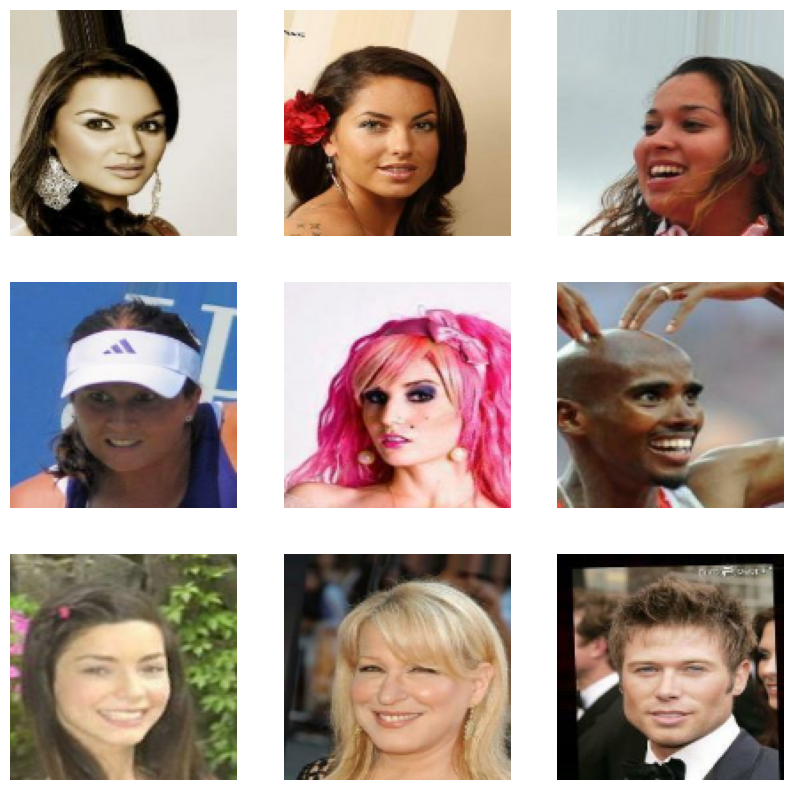

In [12]:
plot_images(train_dataset)

### Custom Sampling layer

In [13]:
class Sampling(tf.keras.layers.Layer):
  def call(self , input):
    z_mean , z_log_var = input
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch , dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [14]:
# Encoder Model Architecture

encoder_input = tf.keras.layers.Input(shape=(IMAGE_SIZE ,IMAGE_SIZE ,CHANNELS) , name = "encoder_input")

conv_1 = tf.keras.layers.Conv2D(NUM_FEATURES , kernel_size=(3,3) , strides = 2 , padding="same" , activation = "relu")
norm_1 = tf.keras.layers.BatchNormalization()
leaky_1 = tf.keras.layers.LeakyReLU()

conv_2 = tf.keras.layers.Conv2D(NUM_FEATURES , kernel_size=(3,3) , strides = 2 , padding="same" , activation = "relu")
norm_2 = tf.keras.layers.BatchNormalization()
leaky_2 = tf.keras.layers.LeakyReLU()

conv_3 = tf.keras.layers.Conv2D(NUM_FEATURES , kernel_size=(3,3) , strides = 2 , padding="same" , activation = "relu")
norm_3 = tf.keras.layers.BatchNormalization()
leaky_3 = tf.keras.layers.LeakyReLU()

conv_4 = tf.keras.layers.Conv2D(NUM_FEATURES , kernel_size=(3,3) , strides = 2 , padding="same" , activation = "relu")
norm_4 = tf.keras.layers.BatchNormalization()
leaky_4 = tf.keras.layers.LeakyReLU()

flatten = tf.keras.layers.Flatten()
dense_1 = tf.keras.layers.Dense(Z_DIM , name = "z_mean")
dense_2 = tf.keras.layers.Dense(Z_DIM , name = "z_log_var")

x = conv_1(encoder_input)
x = norm_1(x)
x = leaky_1(x)

x = conv_2(x)
x = norm_2(x)
x = leaky_2(x)

x = conv_3(x)
x = norm_3(x)
x = leaky_3(x)

x = conv_4(x)
x = norm_4(x)
x = leaky_4(x)

shape_before_flatten = K.int_shape(x)[1 : ]

x = flatten(x)
z_mean = dense_1(x)
z_log_var = dense_2(x)

z = Sampling()([z_mean , z_log_var])

encoder = tf.keras.models.Model(encoder_input , [z_mean , z_log_var , z] , name = "encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 128)          3584      ['encoder_input[0][0]']       
                                                                                                  
 batch_normalization (Batch  (None, 64, 64, 128)          512       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 128)          0         ['batch_normalization[0]

In [15]:
shape_before_flatten

(8, 8, 128)

In [16]:
# Decoder Model Architecture

decoder_input = tf.keras.layers.Input(shape=(Z_DIM,) , name = "decoder_input")
dense_1 = tf.keras.layers.Dense(np.prod(shape_before_flatten))

norm_1 = tf.keras.layers.BatchNormalization()
leaky_1 = tf.keras.layers.LeakyReLU()
reshape = tf.keras.layers.Reshape(shape_before_flatten)
conv_transpose_1 = tf.keras.layers.Conv2DTranspose(NUM_FEATURES , kernel_size=(3,3) , strides = 2 , padding="same" )

norm_2 = tf.keras.layers.BatchNormalization()
leaky_2 = tf.keras.layers.LeakyReLU()
conv_transpose_2 = tf.keras.layers.Conv2DTranspose(NUM_FEATURES , kernel_size=(3,3) , strides = 2 , padding="same" )

norm_3 = tf.keras.layers.BatchNormalization()
leaky_3 = tf.keras.layers.LeakyReLU()
conv_transpose_3 = tf.keras.layers.Conv2DTranspose(NUM_FEATURES , kernel_size=(3,3) , strides = 2 , padding="same" )

norm_4 = tf.keras.layers.BatchNormalization()
leaky_4 = tf.keras.layers.LeakyReLU()
conv_transpose_4 = tf.keras.layers.Conv2DTranspose(NUM_FEATURES , kernel_size=(3,3) , strides = 2 , padding="same" )

norm_5 = tf.keras.layers.BatchNormalization()
leaky_5 = tf.keras.layers.LeakyReLU()
conv_transpose_5 = tf.keras.layers.Conv2DTranspose(CHANNELS , kernel_size=(3,3) , strides = 1 , padding="same" , activation = "sigmoid")

x = dense_1(decoder_input)

x = norm_1(x)
x = leaky_1(x)
x = reshape(x)
x = conv_transpose_1(x)

x = norm_2(x)
x = leaky_2(x)
x = conv_transpose_2(x)

x = norm_3(x)
x = leaky_3(x)
x = conv_transpose_3(x)

x = norm_4(x)
x = leaky_4(x)
x = conv_transpose_4(x)

x = norm_5(x)
x = leaky_5(x)
decoder_output = conv_transpose_5(x)

decoder = tf.keras.models.Model(decoder_input , decoder_output , name = "decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 200)]             0         
                                                                 
 dense (Dense)               (None, 8192)              1646592   
                                                                 
 batch_normalization_4 (Bat  (None, 8192)              32768     
 chNormalization)                                                
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 128)       147584    
 anspose)                                                  

In [17]:
class VAE(tf.keras.models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def get_config(self):
        config = super(VAE , self).get_config()
        config.update({
            "encoder" : self.encoder,
            "decoder" : self.decoder
        })
        return config

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data, training=True)
            reconstruction_loss = tf.reduce_mean(
                BETA * tf.keras.losses.mean_squared_error(data, reconstruction)
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }



In [18]:
vae = VAE(encoder, decoder)

In [19]:
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE))

In [20]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = "./checkpoint/vae.keras",
    save_freq = "epoch",
    save_weights_only = False,
    monitor = "loss",
    mode = "min",
    save_best_only = True,
    verbose=0
)

In [21]:
history = vae.fit(
    train_dataset,
    epochs=EPOCHS,
    callbacks=[model_checkpoint]
)

Epoch 1/40
41/41 [==============================] - 77s 2s/step - loss: 352.9520 - reconstruction_loss: 138.7178 - kl_loss: 110.7161
Epoch 2/40
41/41 [==============================] - 73s 2s/step - loss: 168.0804 - reconstruction_loss: 95.2045 - kl_loss: 55.6264
Epoch 3/40
41/41 [==============================] - 73s 2s/step - loss: 140.0966 - reconstruction_loss: 85.7316 - kl_loss: 45.1577
Epoch 4/40
41/41 [==============================] - 74s 2s/step - loss: 127.6579 - reconstruction_loss: 80.4672 - kl_loss: 40.7164
Epoch 5/40
41/41 [==============================] - 73s 2s/step - loss: 123.2583 - reconstruction_loss: 77.6456 - kl_loss: 37.3390
Epoch 6/40
41/41 [==============================] - 73s 2s/step - loss: 120.9674 - reconstruction_loss: 76.6931 - kl_loss: 37.6109
Epoch 7/40
41/41 [==============================] - 72s 2s/step - loss: 111.0121 - reconstruction_loss: 72.5569 - kl_loss: 32.7753
Epoch 8/40
41/41 [==============================] - 71s 2s/step - loss: 101.5594 

### Saving thr encoder and decoder models along with the weights of the **vae** model

In [23]:
! mkdir ./model

In [24]:
encoder.save("./model/encoder.keras")
decoder.save("./model/decoder.keras")

In [25]:
vae.save_weights('./checkpoint/weights')


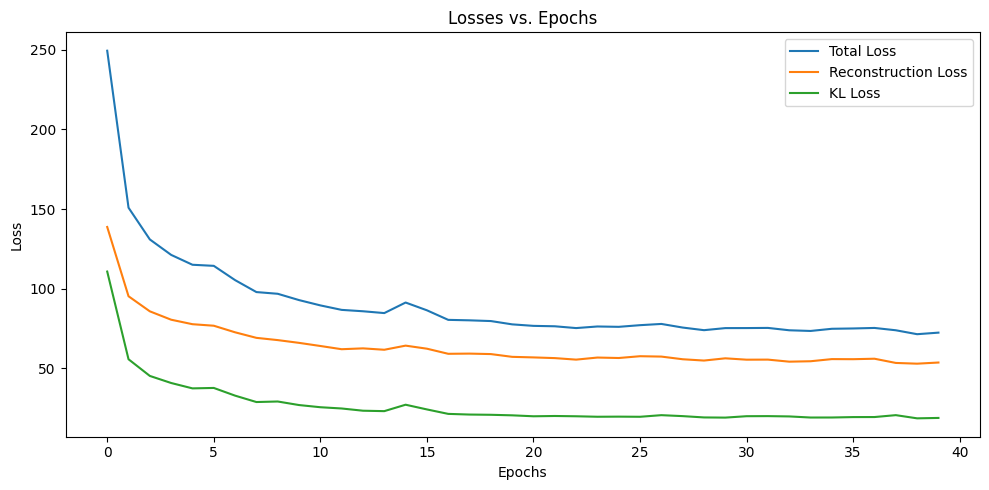

In [26]:
plt.figure(figsize=(10 , 5))
plt.plot(history.history["loss"] , label="Total Loss")
plt.plot(history.history['reconstruction_loss'], label='Reconstruction Loss')
plt.plot(history.history['kl_loss'], label='KL Loss')
plt.title('Losses vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
save_fig("loss_plot")
plt.show()

 You should ideally see all three losses decreasing over the training epochs. This demonstrates the VAE is progressively learning to better reconstruct images and regularize its latent space.
 But after 6-7th epochs the decrease in the value of the losses are very low .

# Generating an image from the training set .

In [27]:
ex = list(train_dataset.take(1))
ex[0].shape

TensorShape([64, 128, 128, 3])

In [28]:
encoder_ex = encoder.predict(ex[0])[0]
encoder_ex.shape

2/2 [==============================] - 0s 47ms/step


(64, 200)

In [29]:
decoder_ex = decoder.predict(encoder_ex)
decoder_ex.shape

2/2 [==============================] - 1s 376ms/step


(64, 128, 128, 3)

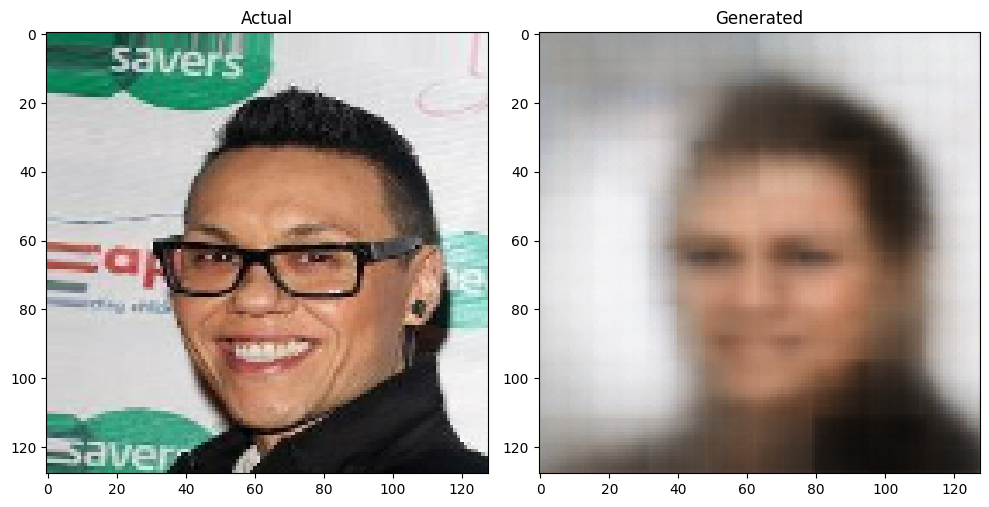

In [30]:
fig = plt.figure(figsize=(10 , 5))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(ex[0][0])
ax.set_title("Actual")
ax = fig.add_subplot(1, 2, 2)
ax.imshow(decoder_ex[0])
ax.set_title("Generated")
save_fig("actual_vs_generated")
plt.show()

# Generating new faces

In [31]:
grid_width , grid_height = (10 , 3)
z_sample = np.random.normal(size=(grid_width * grid_height , Z_DIM))

In [32]:
reconstruct = decoder.predict(z_sample)

1/1 [==============================] - 1s 516ms/step


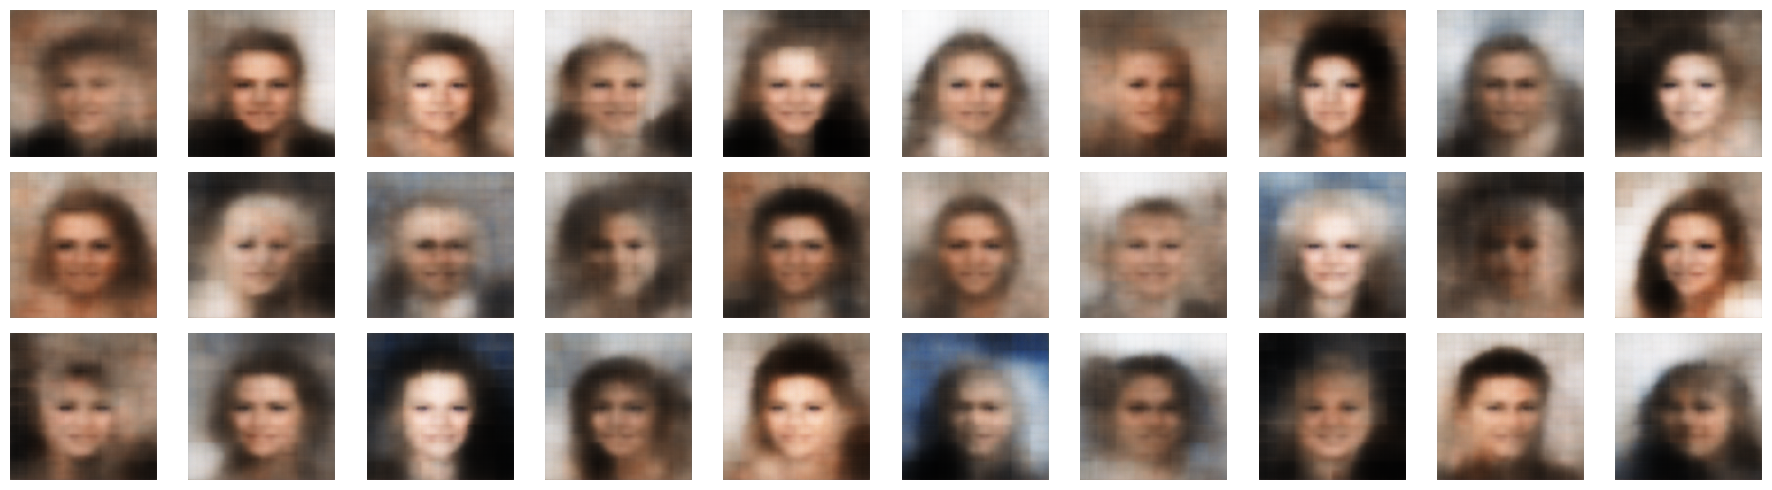

In [33]:
fig = plt.figure(figsize=(18,5))
fig.subplots_adjust(hspace=0.4 , wspace=0.4)

for i in range(grid_width * grid_height):
  ax = fig.add_subplot(grid_height , grid_width , i + 1)
  ax.imshow(reconstruct[i , : ,:])
  ax.axis("off")
save_fig("New Generated Images")
plt.show()

Some of the deatils are missing from the reconstructed face but we have to remember that the goal of the VAE is not to generate absolute real face or zero reconstruction loss but to be able to sample from the **latent space** in order to generate new face .